In [2]:
# Check what Colab already has
import sys, subprocess, importlib

def ensure(pkg, ver=None):
    try:
        m = importlib.import_module(pkg)
        if ver: print(f"{pkg} OK ({m.__version__})")
        else: print(f"{pkg} OK")
    except Exception:
        if ver:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}=={ver}", "-q"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
        print(f"Installed {pkg}")

# Use preinstalled TF & sklearn; install lightgbm only if needed
ensure("numpy")
ensure("pandas")
ensure("matplotlib")
ensure("seaborn")
ensure("sklearn")
try:
    import lightgbm
    print("lightgbm OK")
except Exception:
    ensure("lightgbm", "4.5.0")

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import sklearn, lightgbm, tensorflow as tf
print("Ready. TF:", tf.__version__)


numpy OK
pandas OK
matplotlib OK
seaborn OK
sklearn OK
lightgbm OK
Ready. TF: 2.19.0


In [3]:
from google.colab import files
uploaded = files.upload()
# Select:
#  olist_orders_dataset.csv
#  olist_order_items_dataset.csv
#  olist_products_dataset.csv
#  olist_order_payments_dataset.csv
#  olist_customers_dataset.csv
#  product_category_name_translation.csv


Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv


In [4]:
#Load -> Join -> Features -> Super-categories
import pandas as pd, numpy as np

orders      = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products    = pd.read_csv("olist_products_dataset.csv")
payments    = pd.read_csv("olist_order_payments_dataset.csv")
customers   = pd.read_csv("olist_customers_dataset.csv")
cat_map     = pd.read_csv("product_category_name_translation.csv")


In [5]:
# keep delivered
orders = orders[orders["order_status"].eq("delivered")].copy()

In [6]:
# payments to order-level
pay_agg = (payments.groupby("order_id")
    .agg(payment_installments=("payment_installments","max"),
         payment_types=("payment_type", lambda x: "|".join(sorted(x.unique()))),
         payment_value=("payment_value","sum"))
    .reset_index())

In [7]:
# join items -> products -> orders -> payments
df = (order_items
      .merge(products, on="product_id", how="left")
      .merge(orders[["order_id","customer_id","order_purchase_timestamp","order_delivered_customer_date"]],
             on="order_id", how="left")
      .merge(pay_agg, on="order_id", how="left"))

In [8]:
# timestamps + derived
for c in ["order_purchase_timestamp","order_delivered_customer_date"]:
    df[c] = pd.to_datetime(df[c])
df["purchase_to_delivery_days"] = (df["order_delivered_customer_date"]-df["order_purchase_timestamp"]).dt.days
df["month"]   = df["order_purchase_timestamp"].dt.month
df["weekday"] = df["order_purchase_timestamp"].dt.weekday

In [9]:
# product volume + freight ratio
df["product_volume_cm3"] = df[["product_length_cm","product_height_cm","product_width_cm"]].prod(axis=1)
df["freight_ratio"] = df["freight_value"] / df["price"].replace(0, np.nan)


In [10]:
# translate to english and bucket to ~9 super-categories
cat_map.columns = ["pt","category_en"]
df = df.merge(cat_map, left_on="product_category_name", right_on="pt", how="left")
df["category_en"] = df["category_en"].fillna("other")

In [11]:
def to_super(cat):
    c = str(cat).lower()
    if any(k in c for k in ["computer","electronic","audio","phone","camera","tablet","console"]): return "Electronics"
    if any(k in c for k in ["furniture","decor","house","kitchen","bed","bath","garden","office"]): return "Home"
    if any(k in c for k in ["fashion","apparel","luggage","accessories","shoes","clothes"]): return "Fashion"
    if any(k in c for k in ["beauty","health","perfume","personal","hygiene"]): return "Beauty"
    if any(k in c for k in ["sports","toy","baby","cool"]): return "Sports_Toys"
    if any(k in c for k in ["auto","car"]): return "Automotive"
    if any(k in c for k in ["book","stationery","paper","art"]): return "Books_Stationery"
    if any(k in c for k in ["pet","agro"]): return "Pet"
    return "Other"

In [12]:
df["super_category"] = df["category_en"].map(to_super)

In [13]:
# minimal cleaning
df = df.dropna(subset=["super_category","price","freight_value","product_weight_g","payment_value"])
print("Class distribution:\n", df["super_category"].value_counts(normalize=True).round(3))

Class distribution:
 super_category
Home                0.299
Other               0.179
Sports_Toys         0.174
Beauty              0.117
Electronics         0.110
Automotive          0.038
Fashion             0.033
Books_Stationery    0.033
Pet                 0.019
Name: proportion, dtype: float64


In [ ]:
# Product super-category classifier (Logistic vs LightGBM)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
from lightgbm import LGBMClassifier


In [36]:
X = df[["price","freight_value","freight_ratio","product_weight_g","product_volume_cm3",
        "payment_installments","payment_value","payment_types","month","weekday","purchase_to_delivery_days"]]
y = df["super_category"]

num_cols = ["price","freight_value","freight_ratio","product_weight_g","product_volume_cm3",
            "payment_installments","payment_value","month","weekday","purchase_to_delivery_days"]
cat_cols = ["payment_types"]

Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


=== HistGradientBoosting ===
                  precision    recall  f1-score   support

      Automotive      0.356     0.571     0.439       847
          Beauty      0.598     0.620     0.609      2625
Books_Stationery      0.319     0.644     0.427       735
     Electronics      0.612     0.696     0.651      2476
         Fashion      0.380     0.722     0.498       737
            Home      0.756     0.675     0.713      6724
           Other      0.767     0.506     0.610      4026
             Pet      0.237     0.611     0.342       432
     Sports_Toys      0.623     0.473     0.538      3924

        accuracy                          0.601     22526
       macro avg      0.517     0.613     0.536     22526
    weighted avg      0.649     0.601     0.611     22526



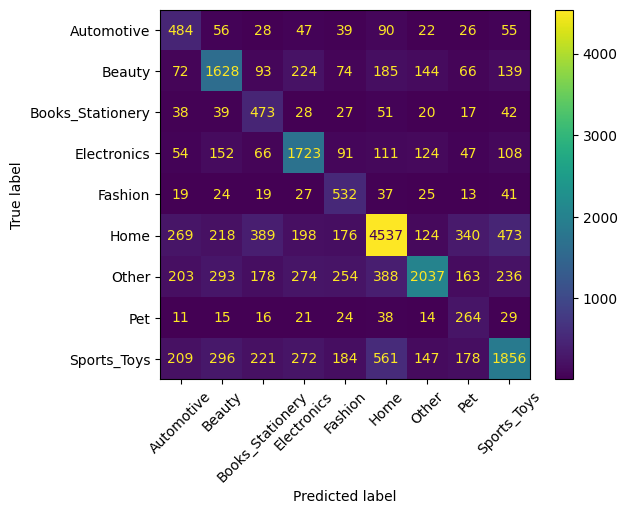

=== RandomForest (balanced_subsample) ===
                  precision    recall  f1-score   support

      Automotive      0.853     0.616     0.716       847
          Beauty      0.824     0.793     0.808      2625
Books_Stationery      0.849     0.673     0.751       735
     Electronics      0.825     0.844     0.834      2476
         Fashion      0.810     0.716     0.760       737
            Home      0.812     0.910     0.858      6724
           Other      0.828     0.787     0.807      4026
             Pet      0.887     0.616     0.727       432
     Sports_Toys      0.770     0.775     0.773      3924

        accuracy                          0.813     22526
       macro avg      0.829     0.748     0.782     22526
    weighted avg      0.814     0.813     0.811     22526



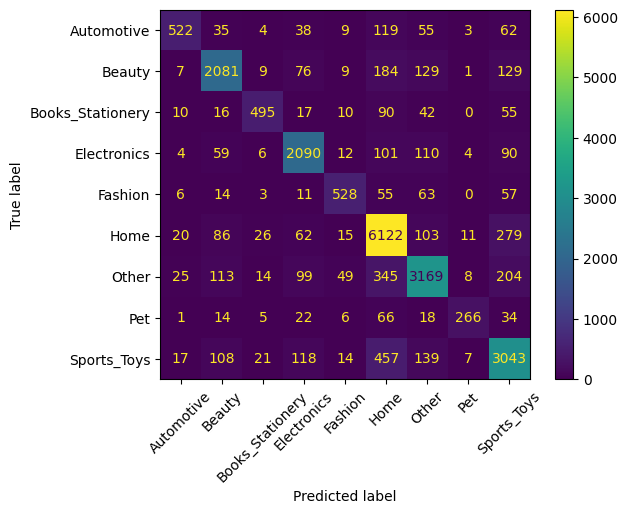

In [37]:
# === TASK-1: Strong non-linear baselines (no LR) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

# 0) Build engineered features (if not already built)
if 'X2' not in globals():
    X2 = df[[
        "price","freight_value","freight_ratio","product_weight_g","product_volume_cm3",
        "payment_installments","payment_value","payment_types","month","weekday","purchase_to_delivery_days"
    ]].copy()
    X2 = X2.replace([np.inf, -np.inf], np.nan)
    for c in ["price","freight_value","product_weight_g","product_volume_cm3","payment_value"]:
        X2[f"log1p_{c}"] = np.log1p(X2[c])
    X2["freight_ratio"] = X2["freight_ratio"].clip(0, 5)
    for p in ["credit_card","boleto","voucher","debit_card"]:
        X2[f"pay_{p}"] = X2["payment_types"].fillna("").str.contains(p).astype(int)
    X2 = X2.drop(columns=["payment_types"])
    y2 = df["super_category"]

Xtr2, Xte2, ytr2, yte2 = train_test_split(X2, y2, stratify=y2, test_size=0.2, random_state=42)

# class weights → sample weights (for models without class_weight arg)
classes, counts = np.unique(ytr2, return_counts=True)
inv_freq = {c: (len(ytr2) / (len(classes)*n)) for c, n in zip(classes, counts)}
sw = np.array([inv_freq[c] for c in ytr2], dtype=float)

# 1) HistGradientBoosting (fast, strong)
hgb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    # (Optional) scaling not needed for trees; keep features numeric from above.
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.07,
        max_depth=None,           # let it grow with regularization
        max_leaf_nodes=31,
        min_samples_leaf=40,
        l2_regularization=1.0,
        early_stopping=True,
        random_state=42
    ))
])
hgb.fit(Xtr2, ytr2, clf__sample_weight=sw)
pred_hgb = hgb.predict(Xte2)
print("=== HistGradientBoosting ===")
print(classification_report(yte2, pred_hgb, digits=3))
ConfusionMatrixDisplay.from_estimator(hgb, Xte2, yte2, xticks_rotation=45); plt.show()

# 2) RandomForest (handles imbalance via class_weight)
rf = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=700,
        max_depth=None,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])
rf.fit(Xtr2, ytr2)
pred_rf = rf.predict(Xte2)
print("=== RandomForest (balanced_subsample) ===")
print(classification_report(yte2, pred_rf, digits=3))
ConfusionMatrixDisplay.from_estimator(rf, Xte2, yte2, xticks_rotation=45); plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2955
[LightGBM] [Info] Number of data points in the train set: 90103, number of used features: 19
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.89398	valid_1's multi_logloss: 1.12331
[200]	training's multi_logl

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== LightGBM ===
                  precision    recall  f1-score   support

      Automotive      0.811     0.614     0.699       847
          Beauty      0.815     0.806     0.811      2625
Books_Stationery      0.854     0.669     0.751       735
     Electronics      0.838     0.846     0.842      2476
         Fashion      0.816     0.704     0.756       737
            Home      0.838     0.890     0.863      6724
           Other      0.808     0.796     0.802      4026
             Pet      0.878     0.602     0.714       432
     Sports_Toys      0.745     0.793     0.768      3924

        accuracy                          0.812     22526
       macro avg      0.823     0.747     0.778     22526
    weighted avg      0.813     0.812     0.811     22526



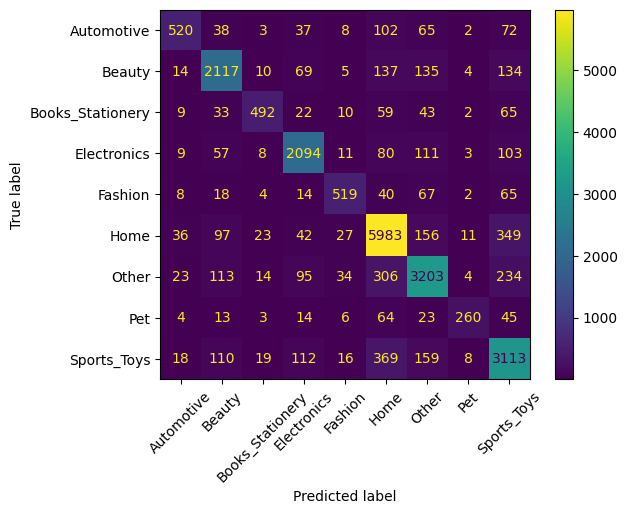

In [38]:
#  LightGBM (engineered features + class weights + early stopping)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import lightgbm as lgb



# 1) Impute numerics once (so we can use early stopping cleanly)
imp = SimpleImputer(strategy="median").fit(Xtr2)
Xtr_i = imp.transform(Xtr2)
Xte_i = imp.transform(Xte2)

# 2) Inverse-frequency class weights
classes, counts = np.unique(ytr2, return_counts=True)
cw = {c: (len(ytr2) / (len(classes) * n)) for c, n in zip(classes, counts)}
sample_w = np.array([cw[c] for c in ytr2], dtype=float)

# 3) Model
clf = lgb.LGBMClassifier(
    objective="multiclass",
    n_estimators=4000,
    learning_rate=0.03,
    num_leaves=127,
    min_child_samples=40,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42
)

# 4) Fit with early stopping (on your test fold for simplicity)
clf.fit(
    Xtr_i, ytr2,
    sample_weight=sample_w,
    eval_set=[(Xtr_i, ytr2), (Xte_i, yte2)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# 5) Evaluate
yp = clf.predict(Xte_i)
print("=== LightGBM ===")
print(classification_report(yte2, yp, digits=3))
ConfusionMatrixDisplay.from_predictions(yte2, yp, xticks_rotation=45); plt.show()


In [ ]:
# Build customer sequences (train/test split on customers)

In [39]:
import numpy as np, pandas as pd

# 1) sort each customer's orders chronologically and collect category sequences
seq_df = (df[["customer_id","order_purchase_timestamp","super_category"]]
          .dropna()
          .sort_values(["customer_id","order_purchase_timestamp"]))

seqs = (seq_df.groupby("customer_id")["super_category"]
        .apply(list).reset_index(name="seq"))

# 2) keep customers with enough history (>=3 purchases total so we can predict next)
seqs = seqs[seqs["seq"].apply(len) >= 3].reset_index(drop=True)
print("Customers kept:", len(seqs))

# 3) label map (freeze class order for reproducibility)
cats = sorted(df["super_category"].dropna().unique())
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}

seqs["seq_id"] = seqs["seq"].apply(lambda s: [cat2id[x] for x in s])

# 4) split by customers (so test customers are unseen)
from sklearn.model_selection import train_test_split
cust_tr, cust_te = train_test_split(seqs["customer_id"], test_size=0.2, random_state=42)
train = seqs[seqs["customer_id"].isin(cust_tr)]
test  = seqs[seqs["customer_id"].isin(cust_te)]

def make_xy(rows):
    X, y = [], []
    for s in rows["seq_id"]:
        # teacher forcing style: predict each next step given history so far
        for t in range(1, len(s)):
            X.append(s[:t]); y.append(s[t])
    return X, np.array(y, dtype=np.int64)

X_train_raw, y_train = make_xy(train)
X_test_raw,  y_test  = make_xy(test)

print(f"Train steps: {len(y_train)} | Test steps: {len(y_test)}")


Customers kept: 2242
Train steps: 5050 | Test steps: 1275


In [40]:
# fixed max length = longest training history
maxlen = max(map(len, X_train_raw))
PAD = len(cats)                      # reserve one index for padding

def pad(seq, L=maxlen, pad_val=PAD):
    return np.array(seq + [pad_val]*(L-len(seq)), dtype=np.int64)

X_train = np.vstack([pad(s) for s in X_train_raw])
X_test  = np.vstack([pad(s) for s in X_test_raw])

# naive baseline: predict the last seen category
y_pred_last = np.array([s[-1] for s in X_test_raw])
top1_last = (y_pred_last == y_test).mean()
print(f"Baseline (Repeat-Last) — Top-1: {top1_last:.3f}")


Baseline (Repeat-Last) — Top-1: 0.968


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# class weights to help rarer categories
classes, counts = np.unique(y_train, return_counts=True)
cw = {int(k): float(len(y_train)/(len(classes)*v)) for k,v in zip(classes, counts)}

vocab_size = len(cats) + 1          # +1 for PAD
embed_dim  = 64
units      = 128

inp = layers.Input(shape=(maxlen,), dtype="int32")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
x = layers.LSTM(units, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(units)(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(len(cats), activation="softmax")(x)

model = models.Model(inp, out)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
hist = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20, batch_size=512,
    callbacks=[es],
    class_weight=cw,
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 64)    │        640 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 20, 128)   │     98,816 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    131,584 │ dropout[0][0],    │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9)         │      1,161 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,201 (907.04 KB)

 Trainable params: 232,201 (907.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - accuracy: 0.0610 - loss: 2.2957 - val_accuracy: 0.3564 - val_loss: 2.1532
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.5050 - loss: 2.1489 - val_accuracy: 0.7248 - val_loss: 0.8535
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - accuracy: 0.7537 - loss: 1.4689 - val_accuracy: 0.8733 - val_loss: 0.5023
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.8356 - loss: 1.1011 - val_accuracy: 0.9505 - val_loss: 0.3866
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 561ms/step - accuracy: 0.9236 - loss: 0.7610 - val_accuracy: 0.9604 - val_loss: 0.2631
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.9499 - loss: 0.5478 - val_accuracy: 0.9644 - val_loss: 0.2540
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.9530 - loss: 0.4680 - val_accuracy: 0.9743 - val_loss: 0.2047
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 567ms/step - accuracy: 0.9715 - loss: 0.2997 - val_accuracy: 0.9743 - val_loss

LSTM (2-layer) — Top-1: 0.972 | Top-3: 0.985 | Baseline Last: 0.968

=== Per-class report (LSTM) ===
                  precision    recall  f1-score   support

      Automotive      0.938     0.882     0.909        34
          Beauty      1.000     0.932     0.965        74
Books_Stationery      1.000     0.850     0.919        20
     Electronics      1.000     1.000     1.000       111
         Fashion      0.875     1.000     0.933        21
            Home      0.975     0.991     0.983       643
           Other      0.949     0.953     0.951       233
             Pet      1.000     1.000     1.000        20
     Sports_Toys      0.974     0.941     0.957       119

        accuracy                          0.972      1275
       macro avg      0.968     0.950     0.957      1275
    weighted avg      0.972     0.972     0.972      1275



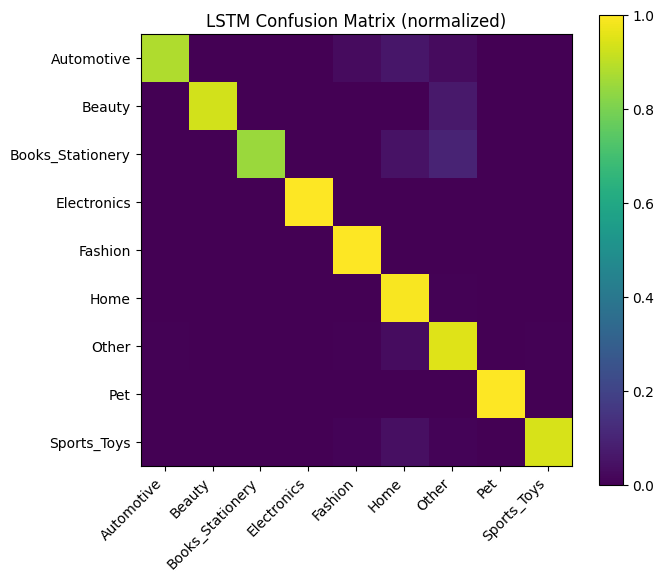

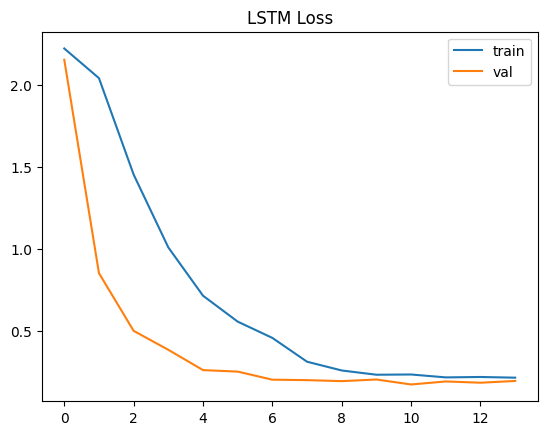

In [42]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

probs = model.predict(X_test, verbose=0)
pred  = probs.argmax(1)

top1 = (pred == y_test).mean()
top3 = (np.argsort(-probs, axis=1)[:, :3] == y_test.reshape(-1,1)).any(axis=1).mean()
print(f"LSTM (2-layer) — Top-1: {top1:.3f} | Top-3: {top3:.3f} | Baseline Last: {top1_last:.3f}")

# per-class precision/recall/f1
print("\n=== Per-class report (LSTM) ===")
print(classification_report(y_test, pred, target_names=[id2cat[i] for i in range(len(cats))], digits=3))

# confusion matrix (normalized by true class)
cm = confusion_matrix(y_test, pred, labels=list(range(len(cats))), normalize='true')
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(cm)
ax.set_xticks(range(len(cats))); ax.set_xticklabels(cats, rotation=45, ha='right')
ax.set_yticks(range(len(cats))); ax.set_yticklabels(cats)
ax.set_title("LSTM Confusion Matrix (normalized)")
fig.colorbar(im); plt.tight_layout(); plt.show()

# training curves
plt.plot(hist.history["loss"], label="train"); plt.plot(hist.history["val_loss"], label="val")
plt.title("LSTM Loss"); plt.legend(); plt.show()


In [43]:
import json, joblib
joblib.dump(model, "task2_lstm_2layer.keras")  # Keras V3 saves with .keras or H5 (use .keras)
with open("task2_label_map.json","w") as f:
    json.dump({"cat2id": cat2id, "id2cat": id2cat, "pad_index": PAD, "maxlen": int(maxlen)}, f)
print("Saved task2_lstm_2layer.keras and task2_label_map.json")


Saved task2_lstm_2layer.keras and task2_label_map.json


In [44]:
#sanity checks
persistence_rate = (y_pred_last == y_test).mean()
print("Persistence rate:", round(persistence_rate, 3))


Persistence rate: 0.968


In [47]:
mask_np = (y_pred_last != y_test)
print("Non-persistent share:", float(mask_np.mean()))
print("Baseline (non-persistent):", float((y_pred_last[mask_np] == y_test[mask_np]).mean()))
print("LSTM (non-persistent):", float((pred[mask_np] == y_test[mask_np]).mean()))


Non-persistent share: 0.03215686274509804
Baseline (non-persistent): 0.0
LSTM (non-persistent): 0.24390243902439024


In [50]:
wins = (pred == y_test) & (y_pred_last != y_test)
import collections
pairs = [(id2cat[X_test_raw[i][-1]], id2cat[y_test[i]]) for i in range(len(y_test)) if wins[i]]
pd.DataFrame(collections.Counter(pairs).most_common(15), columns=["(last_cat → next_cat)", "count"])


,(last_cat → next_cat),count
0,"(Other, Home)",4
1,"(Books_Stationery, Other)",2
2,"(Beauty, Other)",1
3,"(Sports_Toys, Home)",1
4,"(Automotive, Home)",1
5,"(Automotive, Other)",1
